In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

ras = [2500]
splits = ["val", "test", "train"]


def check(check):
    for split in splits:
        for ra in ras:
            path = f"/vol/cfd/rbc/3D/{split}/ra{ra}.h5"
            with h5py.File(path, "r") as file:
                check(file, path)

# Dataset Info

In [7]:
def dataset_info(file, path):
    print(f"file {path} has {file.attrs['episodes']} episodes")


check(dataset_info)

file /vol/cfd/rbc/3D/val/ra2500.h5 has 20 episodes
file /vol/cfd/rbc/3D/test/ra2500.h5 has 20 episodes
file /vol/cfd/rbc/3D/train/ra2500.h5 has 50 episodes


# Validate Temperature

In [8]:
def validate(file, path):
    passed = True
    episodes = file.attrs["episodes"]
    steps = file.attrs["steps"]

    with tqdm(total=episodes, desc="Validating..") as pbar:
        for episode in range(episodes):
            states = file[f"states{episode}"]

            # 1) check number of steps
            if len(states) != steps:
                pbar.write(
                    f"Mismatch in number of steps for episode {episode}: expected {steps}, got {len(states)}"
                )

            for step in range(steps):
                # 2) check shape
                if states[step].shape != (6, 32, 48, 48):
                    pbar.write(
                        f"Unexpected shape at episode {episode}, step {step}: {states[step].shape}"
                    )
                    passed = False

                # 3) check temperature range
                min, max = states[step][0].min(), states[step][0].max()
                if min < 0 or max > 1:
                    pbar.write(
                        f"in file {path} at episode {episode} and step {step} - Temperature: min={min}, max={max}"
                    )
                    passed = False
            pbar.update(1)

        # Final result
        if not passed:
            print(f"File {path} failed validation.")
        else:
            print(
                f"File {path} passed validation with {episodes} episodes and {steps} steps each."
            )


check(validate)

Validating..: 100%|██████████| 20/20 [06:31<00:00, 19.56s/it]


File /vol/cfd/rbc/3D/val/ra2500.h5 passed validation with 20 episodes and 600 steps each.


Validating..: 100%|██████████| 20/20 [06:47<00:00, 20.39s/it]


File /vol/cfd/rbc/3D/test/ra2500.h5 passed validation with 20 episodes and 600 steps each.


Validating..:   2%|▏         | 1/50 [01:07<55:29, 67.95s/it]


KeyboardInterrupt: 

# Mean, Min and Max per channel

Calculating mean, min, max for split val


100%|██████████| 20/20 [03:23<00:00, 10.18s/it]


Means for val split: {'T': [np.float32(0.5002543)], 'u': [np.float32(0.0011098535)], 'v': [np.float32(0.00044332523)], 'w': [np.float32(2.3146632e-15)], 'p_hy': [np.float32(-0.4043521)], 'p_nhy': [np.float32(2.1348708e-12)]}
Mins for val split: {'T': [np.float32(0.0)], 'u': [np.float32(-0.84568137)], 'v': [np.float32(-0.80933386)], 'w': [np.float32(-0.8342866)], 'p_hy': [np.float32(-1.6650492)], 'p_nhy': [np.float32(-0.45795724)]}
Maxs for val split: {'T': [np.float32(1.0)], 'u': [np.float32(0.83250797)], 'v': [np.float32(0.8158943)], 'w': [np.float32(0.8115479)], 'p_hy': [np.float32(-0.0)], 'p_nhy': [np.float32(0.6511713)]}
Stds for val split: {'T': [np.float32(0.23987801)], 'u': [np.float32(0.18649986)], 'v': [np.float32(0.183554)], 'w': [np.float32(0.188507)], 'p_hy': [np.float32(0.33494633)], 'p_nhy': [np.float32(0.14956948)]}


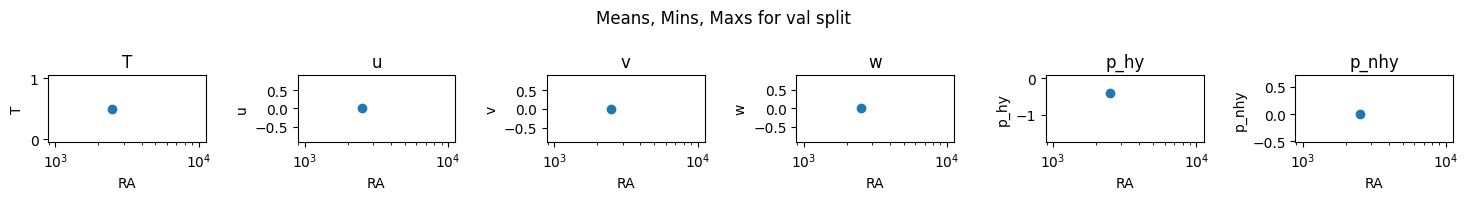

Calculating mean, min, max for split test


100%|██████████| 20/20 [03:04<00:00,  9.24s/it]


Means for test split: {'T': [np.float32(0.50054055)], 'u': [np.float32(-0.0003119237)], 'v': [np.float32(0.0006173)], 'w': [np.float32(-1.3878051e-13)], 'p_hy': [np.float32(-0.40401292)], 'p_nhy': [np.float32(3.874515e-12)]}
Mins for test split: {'T': [np.float32(0.0)], 'u': [np.float32(-0.8543994)], 'v': [np.float32(-0.79257566)], 'w': [np.float32(-0.83483154)], 'p_hy': [np.float32(-1.6703103)], 'p_nhy': [np.float32(-0.45433712)]}
Maxs for test split: {'T': [np.float32(1.0)], 'u': [np.float32(0.84230757)], 'v': [np.float32(0.81680495)], 'w': [np.float32(0.82893944)], 'p_hy': [np.float32(-0.0)], 'p_nhy': [np.float32(0.64193803)]}
Stds for test split: {'T': [np.float32(0.24166968)], 'u': [np.float32(0.19242692)], 'v': [np.float32(0.17401044)], 'w': [np.float32(0.1872441)], 'p_hy': [np.float32(0.33644724)], 'p_nhy': [np.float32(0.15150687)]}


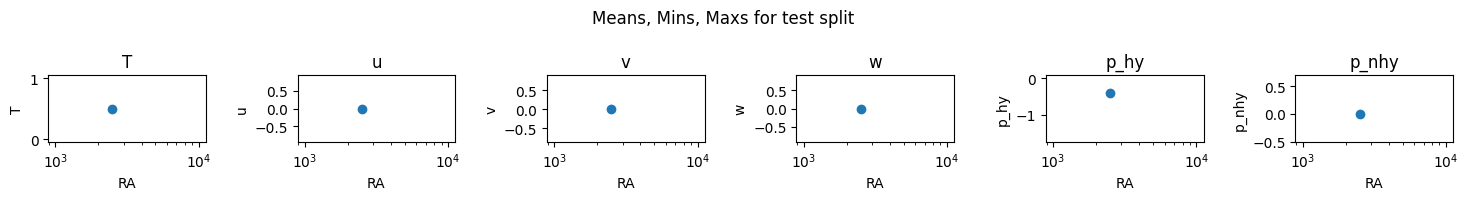

Calculating mean, min, max for split train


 14%|█▍        | 7/50 [01:45<10:45, 15.01s/it]


KeyboardInterrupt: 

In [13]:
def mmms(file, path):
    episodes = file.attrs["episodes"]

    channels = ["T", "u", "v", "w", "p_hy", "p_nhy"]
    means, mins, maxs, stds = {}, {}, {}, {}
    for name in channels:
        means[name] = []
        mins[name] = []
        maxs[name] = []
        stds[name] = []

    for episode in tqdm(range(episodes)):
        # print mean, min, max per channel
        states = np.array(file[f"states{episode}"])

        for ch, name in enumerate(channels):
            means[name].append(states[:, ch, :, :].mean())
            mins[name].append(states[:, ch, :, :].min())
            maxs[name].append(states[:, ch, :, :].max())
            stds[name].append(states[:, ch, :, :].std())

    means = {k: np.mean(v) for k, v in means.items()}
    mins = {k: np.min(v) for k, v in mins.items()}
    maxs = {k: np.max(v) for k, v in maxs.items()}
    stds = {k: np.mean(v) for k, v in stds.items()}
    return means, mins, maxs, stds


for split in splits:
    print(f"Calculating mean, min, max for split {split}")
    channels = ["T", "u", "v", "w", "p_hy", "p_nhy"]
    means, mins, maxs, stds = {}, {}, {}, {}
    for name in channels:
        means[name] = []
        mins[name] = []
        maxs[name] = []
        stds[name] = []

    for ra in ras:
        path = f"/vol/cfd/rbc/3D/{split}/ra{ra}.h5"
        with h5py.File(path, "r") as file:
            mean, min, max, std = mmms(file, path)
            for name in channels:
                means[name].append(mean[name])
                mins[name].append(min[name])
                maxs[name].append(max[name])
                stds[name].append(std[name])

    print(f"Means for {split} split: {means}")
    print(f"Mins for {split} split: {mins}")
    print(f"Maxs for {split} split: {maxs}")
    print(f"Stds for {split} split: {stds}")

    # plot means, mins, maxs
    fig, axs = plt.subplots(1, 6, figsize=(15, 2))
    fig.suptitle(f"Means, Mins, Maxs for {split} split")
    for i, name in enumerate(channels):
        axs[i].plot(ras, means[name], label="Mean", marker="o")
        axs[i].fill_between(
            ras, mins[name], maxs[name], alpha=0.2, label="Min-Max Range"
        )
        axs[i].set_title(name)
        axs[i].set_xlabel("RA")
        axs[i].set_ylabel(name)
        axs[i].set_xscale("log")
    plt.tight_layout()
    plt.show()

# Nusselt Number

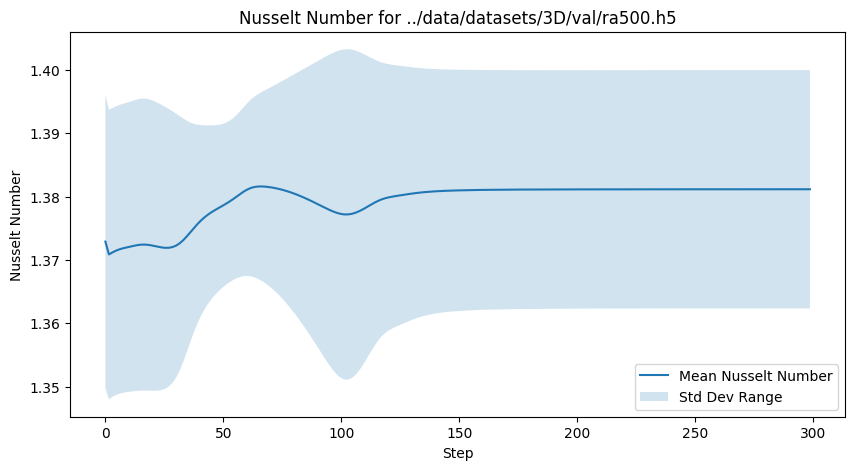

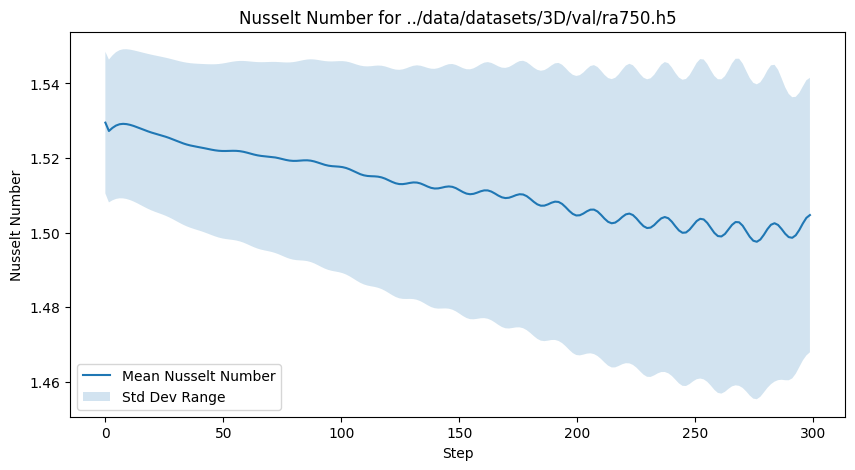

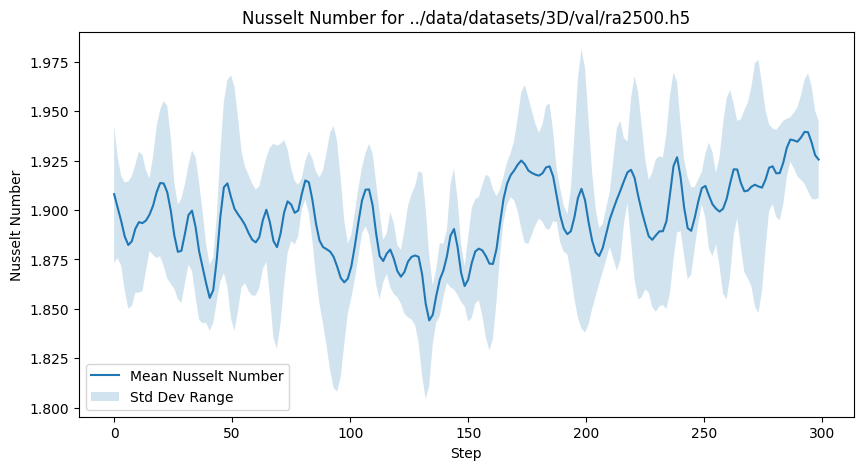

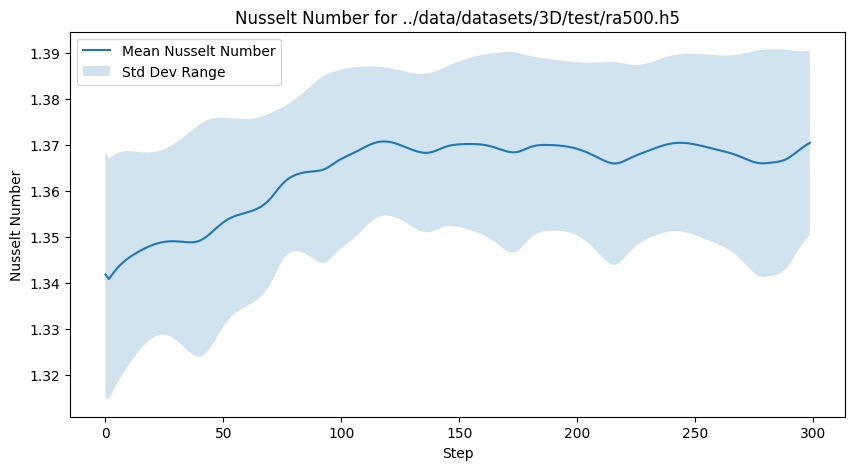

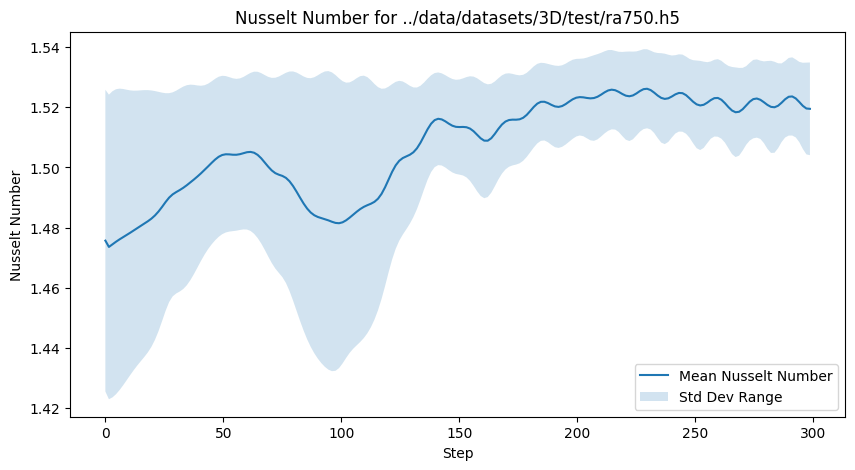

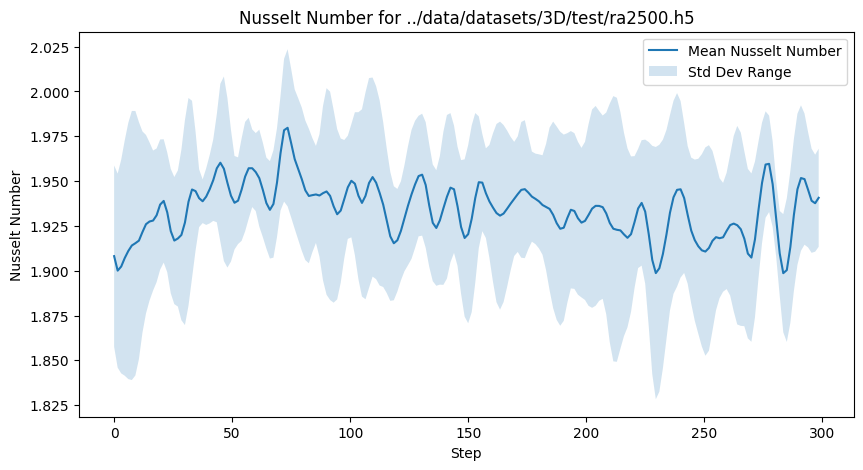

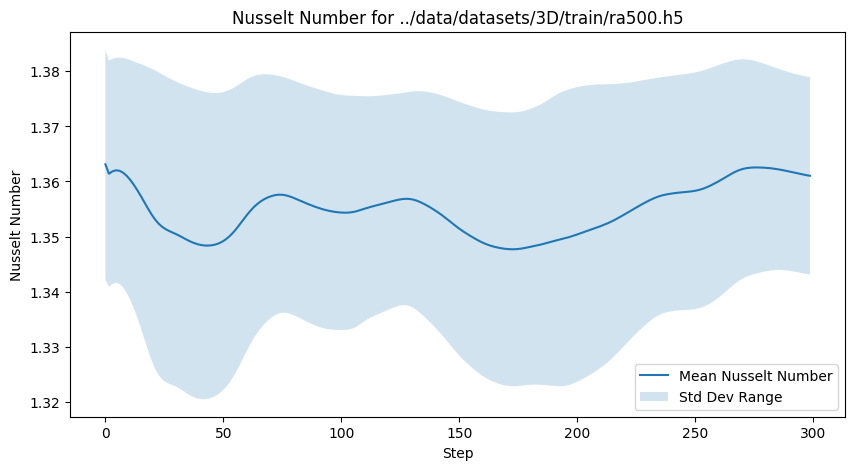

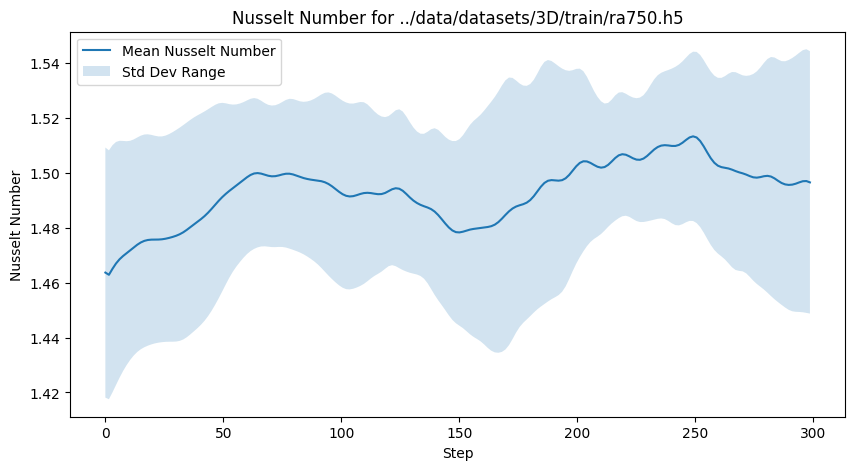

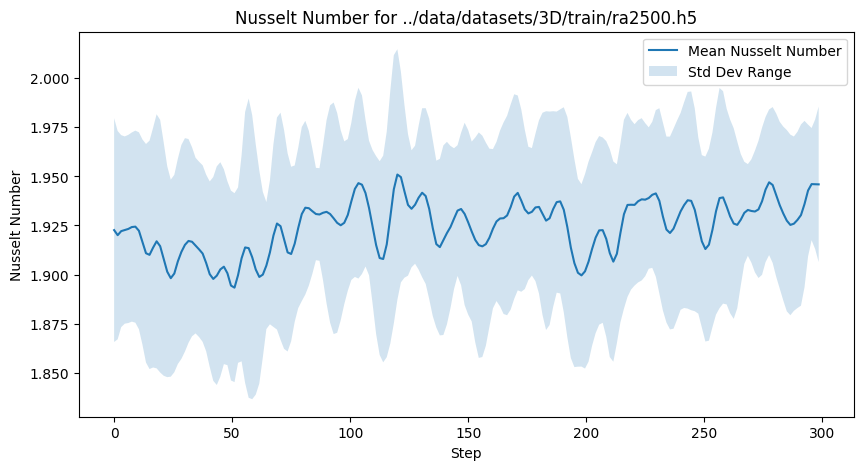

In [13]:
def nu(file, path):
    episodes = file.attrs["episodes"]
    dt = file.attrs["dt"] * 4
    steps = file.attrs["steps"]
    time = np.arange(0, int(steps * dt), dt)

    nus = []
    for episode in range(episodes):
        # print mean, min, max per channel
        nus.append(np.array(file[f"nusselts{episode}"]))
    nus = np.array(nus)
    mean_nu = nus.mean(axis=0)
    std_nu = nus.std(axis=0)

    # plot musselt to step
    plt.figure(figsize=(10, 5))
    plt.plot(time, mean_nu, label="Mean Nusselt Number")
    plt.fill_between(
        time, mean_nu - std_nu, mean_nu + std_nu, alpha=0.2, label="Std Dev Range"
    )
    plt.legend()
    plt.title(f"Nusselt Number for {path}")
    plt.xlabel("Step")
    plt.ylabel("Nusselt Number")
    plt.show()


for split in splits:
    for ra in ras:
        path = f"../data/datasets/3D/{split}/ra{ra}.h5"
        with h5py.File(path, "r") as file:
            nu(file, path)